In [11]:
import pandas as pd
import numpy as np
from pathlib import Path

desktop_candidates = [Path.home() / "Desktop", Path.home() / "桌面"]
desktop_dir = next((d for d in desktop_candidates if d.exists()), None)
if desktop_dir is None:
    raise FileNotFoundError("未找到桌面路径，请将文件完整路径写入 data_path 变量。")

names = ["songs_normalize_new.csv", "songs_normalize_new.xlsx"]
data_path = next((desktop_dir / n for n in names if (desktop_dir / n).exists()), None)
if data_path is None:
    raise FileNotFoundError(f"桌面未找到 {names}，请确认文件名或后缀。")

if data_path.suffix.lower() == ".xlsx":
    df = pd.read_excel(data_path)
else:
  
    df = pd.read_csv(data_path, low_memory=False, encoding="utf-8")

print(f"[INFO] Loaded: {data_path}")
print("[INFO] Shape:", df.shape)
print("[INFO] Columns(sample):", list(df.columns)[:12], "...")

def harmonize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    将常见列名映射为统一字段，便于后续聚合：
    song, artist, genre, year, popularity, key, mode,
    以及九个音频特征：danceability/energy/.../tempo
    """
    rename_map = {
        "track_name": "song", "name": "song", "track": "song",
        "artists": "artist", "artist_name": "artist",
        "genre_top": "genre", "genres": "genre",
        "release_year": "year", "release_date": "release_date",
        "acousticness": "acousticness",
        "danceability": "danceability",
        "energy": "energy",
        "instrumentalness": "instrumentalness",
        "liveness": "liveness",
        "speechiness": "speechiness",
        "valence": "valence",
        "loudness": "loudness",
        "tempo": "tempo",
        "key": "key",
        "mode": "mode",
        "popularity": "popularity",
    }
    for src, dst in rename_map.items():
        if src in df.columns and dst not in df.columns:
            df = df.rename(columns={src: dst})

    # release_date -> year
    if "release_date" in df.columns and "year" not in df.columns:
        df["year"] = pd.to_datetime(df["release_date"], errors="coerce").dt.year

    if "genre" in df.columns and df["genre"].dtype == object:
        def _first_genre(x):
            if pd.isna(x): 
                return np.nan
            s = str(x)
            s = s.strip()
            if s.startswith("[") and s.endswith("]"):
                s = s[1:-1]
            parts = [p.strip().strip("'").strip('"') for p in s.split(",")]
            return parts[0] if parts and parts[0] != "" else np.nan
        df["genre"] = df["genre"].apply(_first_genre)

    for c in ["key", "mode"]:
        if c not in df.columns:
            df[c] = -1

    return df

df = harmonize_columns(df)

num_cols = ["danceability","energy","speechiness","acousticness",
            "instrumentalness","liveness","valence","loudness","tempo",
            "popularity","year","key","mode"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

keep = [c for c in ["danceability","energy","speechiness","acousticness",
                    "instrumentalness","liveness","valence","loudness",
                    "tempo","popularity"] if c in df.columns]
if keep:
    df = df.dropna(subset=keep)
if "tempo" in df.columns:
    df["tempo"] = df["tempo"].clip(40, 220)

if "year" in df.columns:
    df["decade"] = (df["year"] // 10) * 10

print("[INFO] After harmonize:", df.shape)

def save_df(x: pd.DataFrame, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    x.to_csv(path, index=False)

def build_genre_profile(df: pd.DataFrame) -> pd.DataFrame:
    if "genre" not in df.columns:
        return pd.DataFrame()
    base_feats = ["danceability","energy","speechiness","acousticness",
                  "instrumentalness","liveness","valence","loudness","tempo"]
    base_feats = [c for c in base_feats if c in df.columns]

    agg_map = {"song": ("song","count")}
    if "popularity" in df.columns:
        agg_map["popularity_mean"] = ("popularity","mean")
    if "commercial_score" in df.columns:
        agg_map["commercial_mean"] = ("commercial_score","mean")
    for c in base_feats:
        agg_map[f"{c}_mean"] = (c, "mean")

    out = df.groupby("genre").agg(**agg_map).reset_index()
    out = out.rename(columns={"song":"count"})
    return out

def build_yearly_trends(df: pd.DataFrame) -> pd.DataFrame:
    by = "year" if "year" in df.columns else "decade"
    feats = ["danceability","energy","speechiness","acousticness",
             "instrumentalness","liveness","valence","loudness","tempo","popularity"]
    feats = [c for c in feats if c in df.columns]
    out = df.groupby(by).agg({c:"mean" for c in feats}).reset_index().rename(columns={by:"time"})
    if "year" in df.columns:
        out["flag_1999_2005"] = out["time"].between(1999, 2005).astype(int)
    return out

def top10_by_year(df: pd.DataFrame) -> pd.DataFrame:
    if "year" not in df.columns:
        return pd.DataFrame()
    cols = [c for c in ["year","artist","song","genre","popularity"] if c in df.columns]
    return (df.sort_values(["year","popularity"], ascending=[True, False])
              .groupby("year", as_index=False, group_keys=False).head(10)[cols])

def artist_stats(df: pd.DataFrame) -> pd.DataFrame:
    if "artist" not in df.columns:
        return pd.DataFrame()
    agg = {"song": ("song","count")}
    if "popularity" in df.columns:
        agg["popularity_mean"] = ("popularity","mean")
        agg["popularity_max"] = ("popularity","max")
    if "commercial_score" in df.columns:
        agg["commercial_mean"] = ("commercial_score","mean")
    out = df.groupby("artist").agg(**agg).reset_index()
    out = out.rename(columns={"song":"songs"})
    out = out.sort_values(
        ["songs","popularity_mean"] if "popularity_mean" in out.columns else ["songs"],
        ascending=[False, False] if "popularity_mean" in out.columns else [False]
    )
    return out

OUT_DIR = data_path.parent / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

genre_profile = build_genre_profile(df)
yearly_trends = build_yearly_trends(df)
top10 = top10_by_year(df)
artists = artist_stats(df)

if not genre_profile.empty:
    save_df(genre_profile, OUT_DIR / "genre_profile.csv")
if not yearly_trends.empty:
    save_df(yearly_trends, OUT_DIR / "yearly_trends.csv")
if not top10.empty:
    save_df(top10, OUT_DIR / "top10_by_year.csv")
if not artists.empty:
    save_df(artists, OUT_DIR / "artist_stats.csv")

exported = [p.name for p in OUT_DIR.glob("*.csv")]
print(f"[DONE] 导出目录: {OUT_DIR}")
print("[DONE] 导出文件:", exported)

display(genre_profile.head(5) if not genre_profile.empty else pd.DataFrame({"info":["no genre"]}))

[INFO] Loaded: C:\Users\TX\Desktop\songs_normalize_new.csv
[INFO] Shape: (2000, 31)
[INFO] Columns(sample): ['artist', 'song', 'duration_ms', 'explicit', 'year', 'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness'] ...
[INFO] After harmonize: (2000, 31)
[DONE] 导出目录: C:\Users\TX\Desktop\processed
[DONE] 导出文件: ['artist_stats.csv', 'genre_profile.csv', 'top10_by_year.csv', 'yearly_trends.csv']


,genre,count,popularity_mean,commercial_mean,danceability_mean,energy_mean,speechiness_mean,acousticness_mean,instrumentalness_mean,liveness_mean,valence_mean,loudness_mean,tempo_mean
0,Dance/Electronic,41,51.756098,0.679771,0.684610,0.775829,0.059251,0.068404,1.036060e-01,0.183137,0.523585,-5.992390,125.507537
1,Folk/Acoustic,4,56.000000,0.558025,0.512750,0.707500,0.036200,0.249525,1.425000e-05,0.231075,0.447000,-5.711500,111.663250
2,R&B,13,60.461538,0.664815,0.663462,0.688077,0.121123,0.111138,3.329746e-04,0.158254,0.633308,-6.254923,106.924846
3,World/Traditional,10,53.800000,0.637950,0.603000,0.685700,0.079530,0.272961,1.983779e-01,0.194410,0.653700,-6.187800,110.333200
4,country,11,48.181818,0.639100,0.588545,0.751545,0.038718,0.234493,3.500000e-07,0.226873,0.596818,-5.090818,133.650091


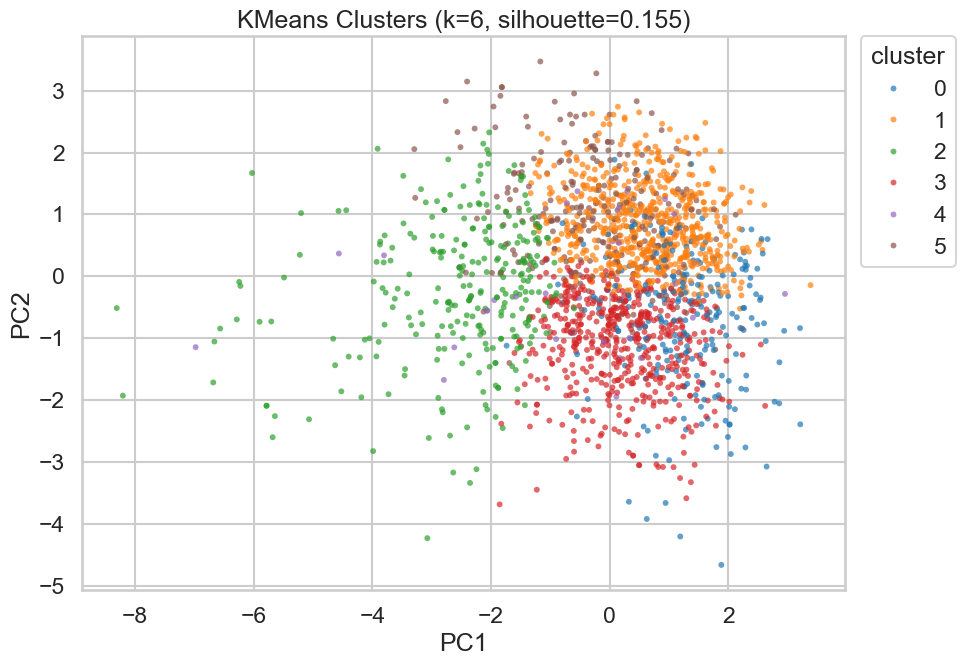

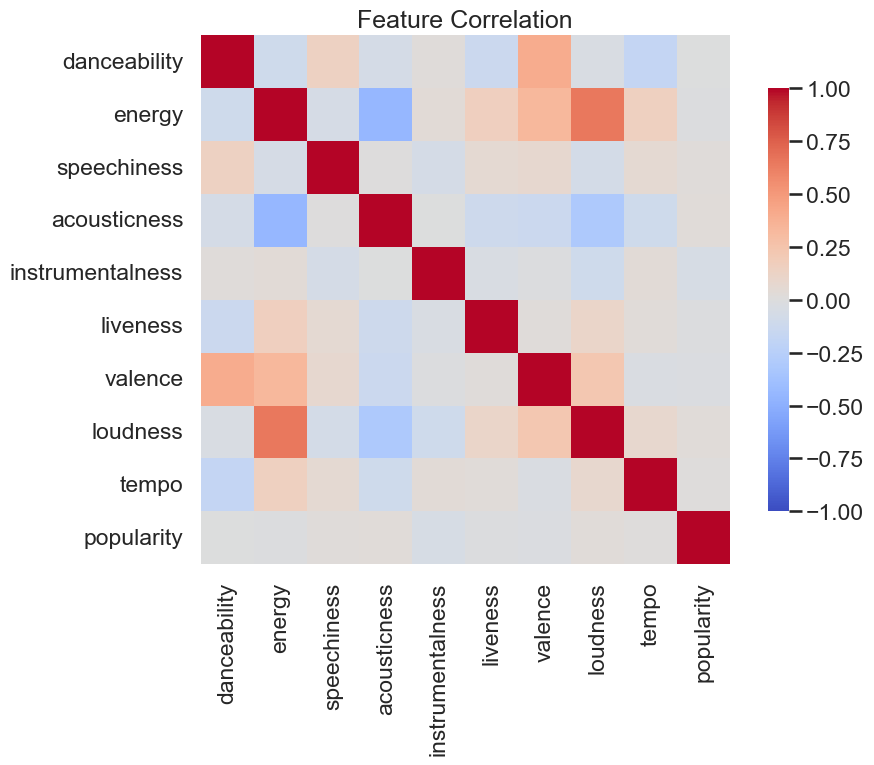

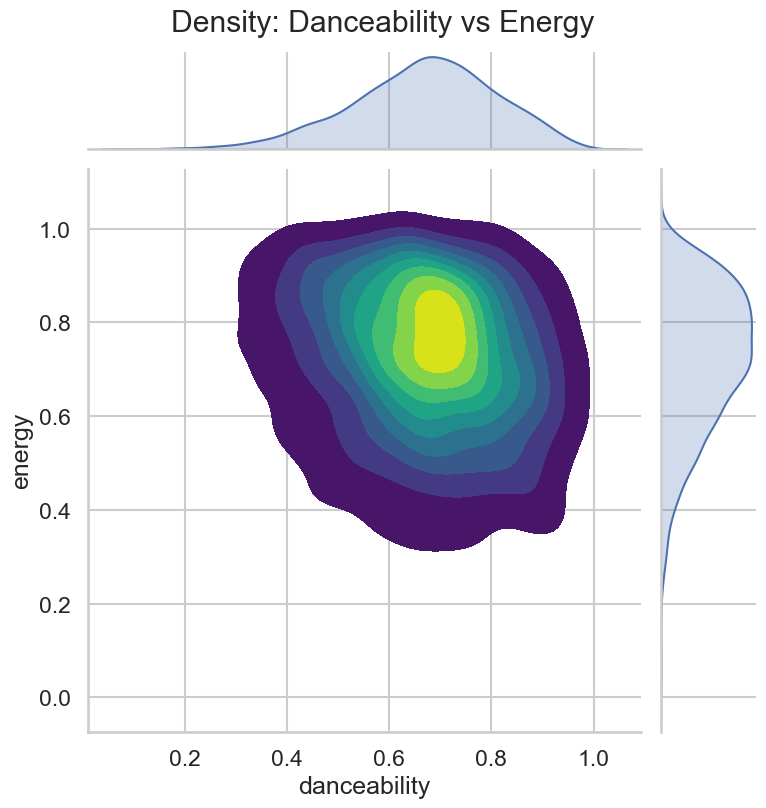

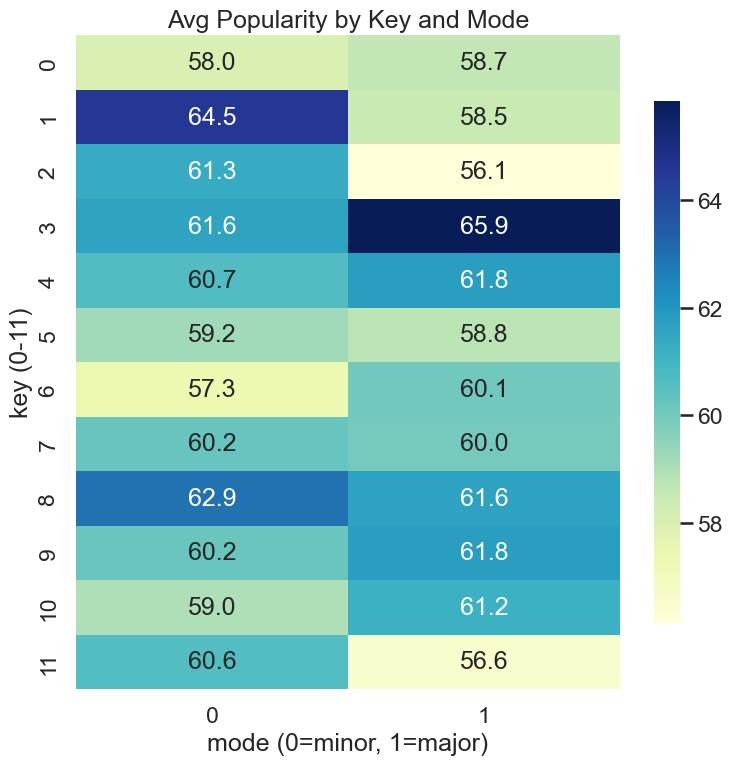

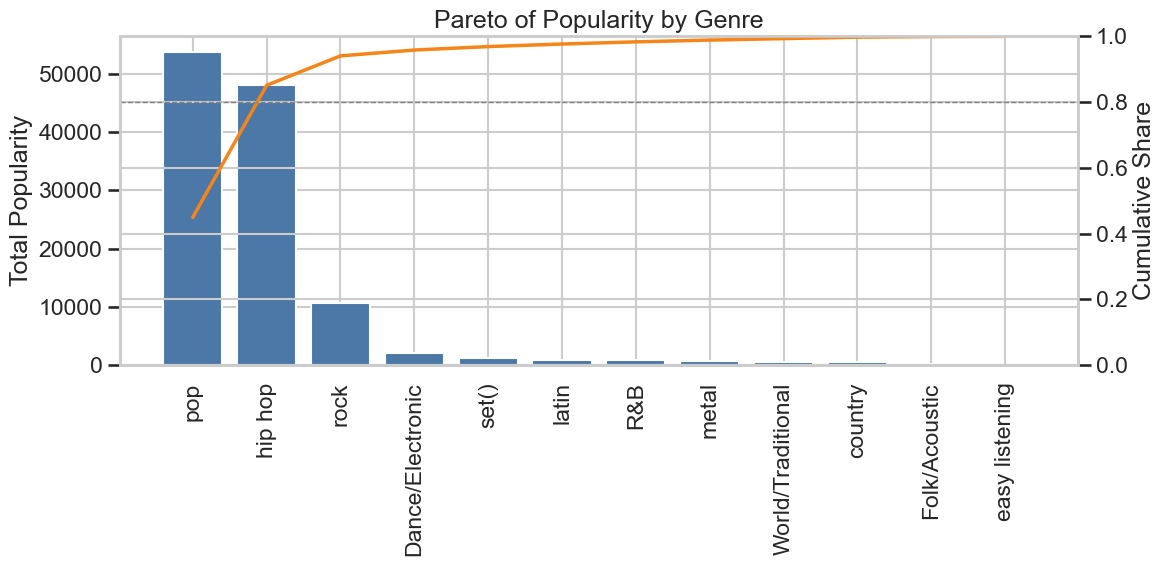

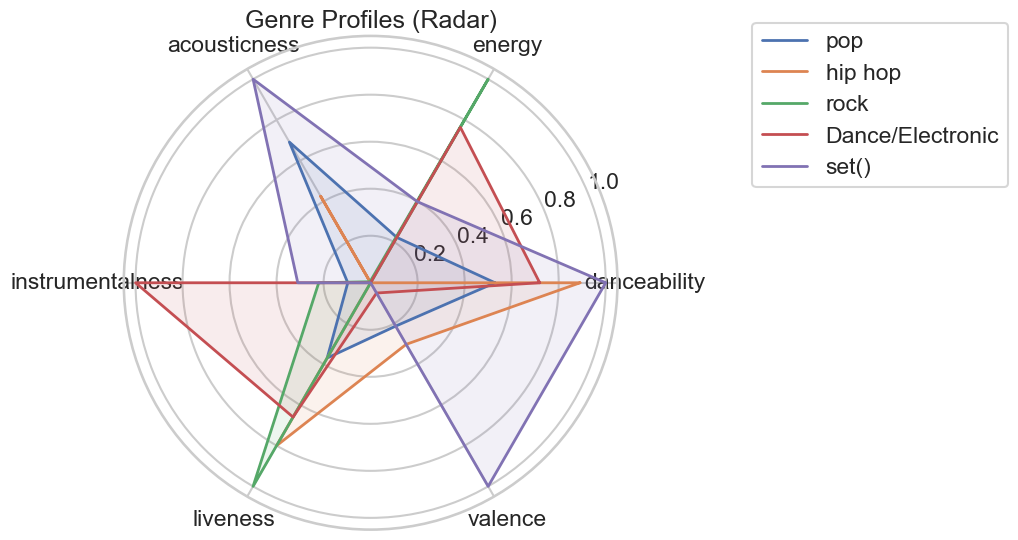

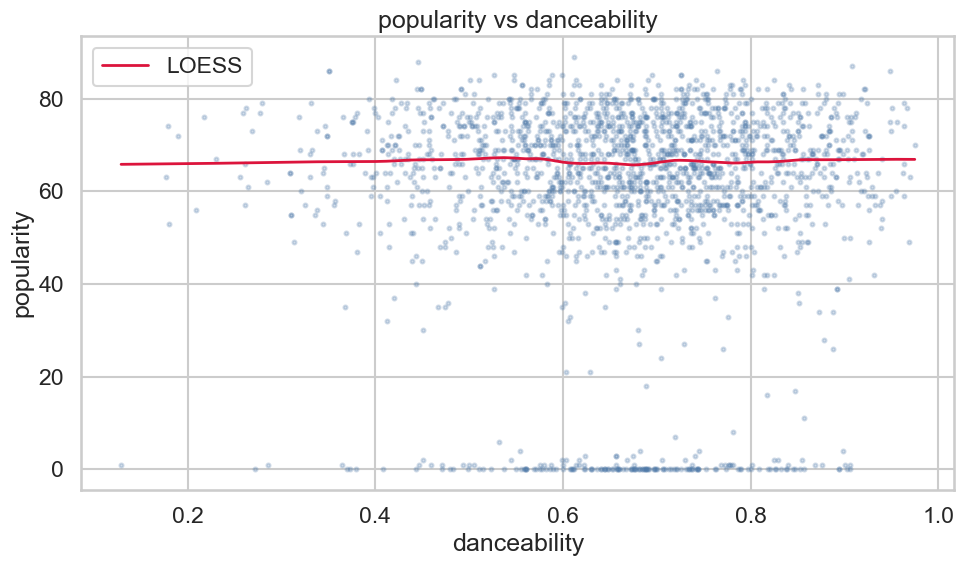

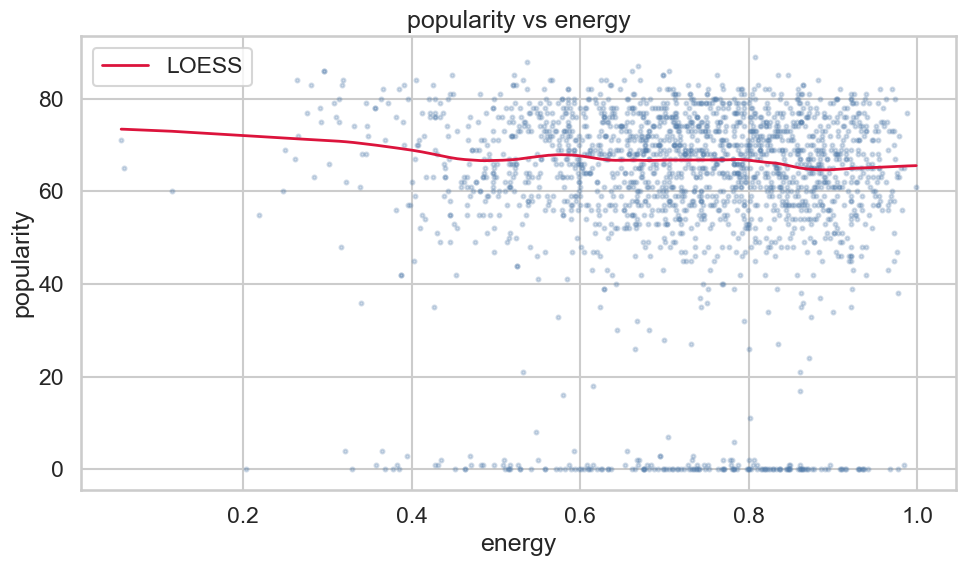

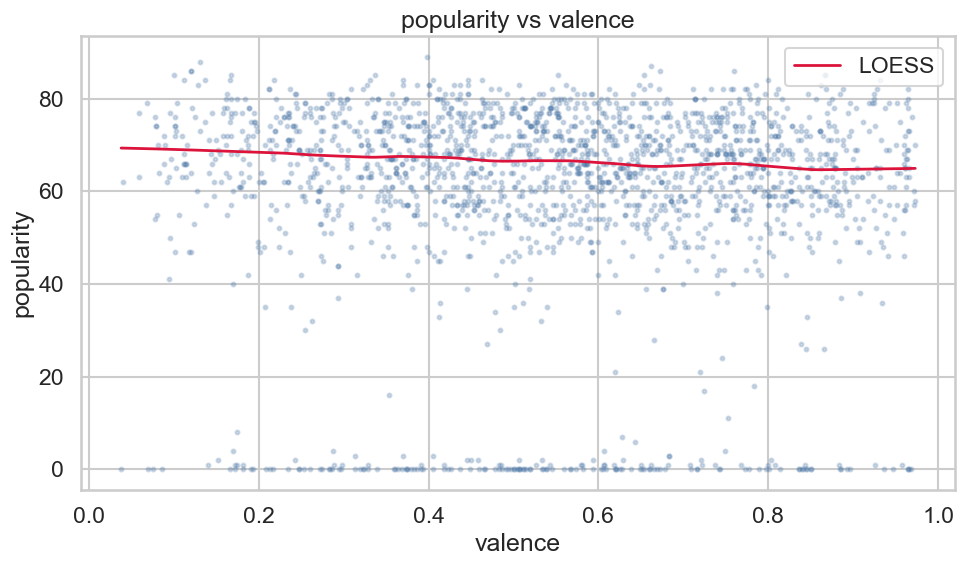

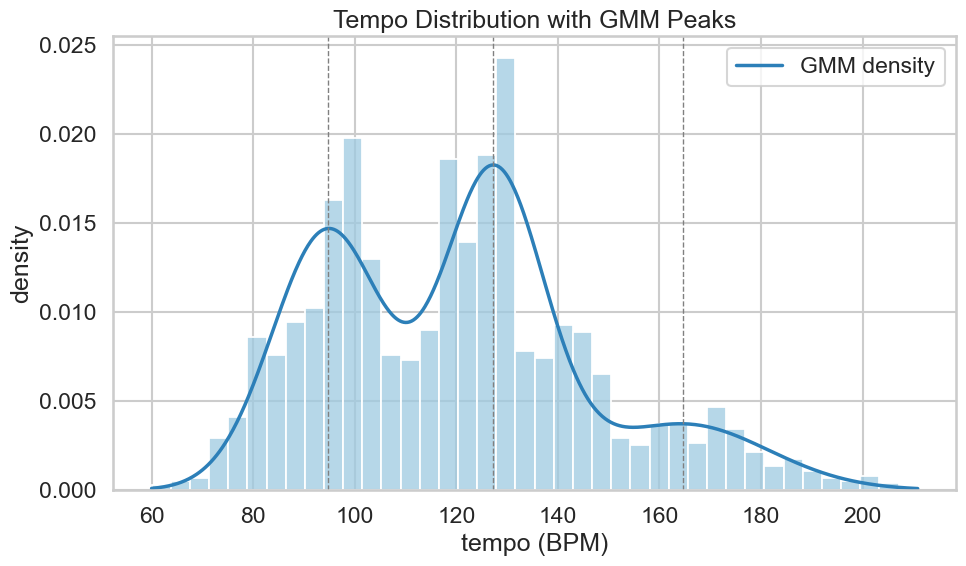

[OK] 图像已保存到： C:\Users\TX\Desktop\figs
['p04_clusters.png', 'p04_corr.png', 'p05_density_dance_energy.png', 'p05_key_mode_heatmap.png', 'p06_pareto_genre.png', 'p06_radar.png', 'p07_loess_danceability.png', 'p07_loess_energy.png', 'p07_loess_valence.png', 'p08_tempo_gmm.png']


In [13]:
# ===== 生成并显示所有图（保存到 <数据文件同目录>/figs） =====
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from statsmodels.nonparametric.smoothers_lowess import lowess

# 复用你之前的 data_path / OUT_DIR，如果没有就用桌面路径
try:
    data_root = data_path.parent
except:
    data_root = Path.home() / "Desktop"

FIG_DIR = data_root / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)

def save_and_show(path: Path, tight=True):
    if tight:
        plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

# 核心特征集合（根据实际存在的列做交集）
ALL_FEATS = [
    "danceability","energy","speechiness","acousticness",
    "instrumentalness","liveness","valence","loudness","tempo"
]
FEATS = [c for c in ALL_FEATS if c in df.columns]

# ---------- 1) 聚类散点 + 相关热力 ----------
if len(FEATS) >= 4:  # 至少若干特征再做PCA/聚类
    X = df[FEATS].to_numpy().astype(float)
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2, random_state=42)
    pc = pca.fit_transform(X)
    df["PC1"], df["PC2"] = pc[:, 0], pc[:, 1]

    # 选 k（或固定 6）
    best_k, best_score, best_model = None, -1, None
    for k in range(4, 9):
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = km.fit_predict(X)
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_k, best_score, best_model = k, score, km
    # 固定 6 如需严格一致：取消下一行注释
    # best_k, best_model = 6, KMeans(n_clusters=6, random_state=42, n_init="auto").fit(X)

    df["cluster"] = best_model.predict(X)

    # 保存 cluster_assignments（可直接给Tableau用）
    cols = [c for c in ["artist","song","genre","year","popularity"] if c in df.columns]
    cols += FEATS + ["PC1","PC2","cluster"]
    df[cols].to_csv(data_root / "cluster_assignments.csv", index=False)

    # 聚类散点
    plt.figure(figsize=(10, 7))
    ax = sns.scatterplot(
        data=df.sample(min(len(df), 8000), random_state=42), # 防止点太多
        x="PC1", y="PC2", hue="cluster", palette="tab10", s=18, alpha=0.7, linewidth=0
    )
    ax.set_title(f"KMeans Clusters (k={df['cluster'].nunique()}, silhouette={best_score:.3f})")
    ax.legend(title="cluster", bbox_to_anchor=(1.02, 1), borderaxespad=0)
    save_and_show(FIG_DIR / "p04_clusters.png")
else:
    print("[skip] PCA/聚类：可用特征不足")

# 相关热力（含 popularity）
corr_cols = FEATS + (["popularity"] if "popularity" in df.columns else [])
if len(corr_cols) >= 2:
    corr = df[corr_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", square=True, cbar_kws={"shrink":0.8})
    plt.title("Feature Correlation")
    save_and_show(FIG_DIR / "p04_corr.png")

# ---------- 2) 密度(danceability vs energy) + Key×Mode ----------
if all(c in df.columns for c in ["danceability","energy"]):
    g = sns.jointplot(
        data=df.sample(min(len(df), 15000), random_state=42),
        x="danceability", y="energy",
        kind="kde", fill=True, cmap="viridis", thresh=0.05, height=8
    )
    g.fig.suptitle("Density: Danceability vs Energy", y=1.02)
    g.savefig(FIG_DIR / "p05_density_dance_energy.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(g.fig)

if all(c in df.columns for c in ["key","mode","popularity"]):
    piv = df.pivot_table(index="key", columns="mode", values="popularity", aggfunc="mean").sort_index()
    plt.figure(figsize=(8, 8))
    sns.heatmap(piv, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={"shrink":0.8})
    plt.title("Avg Popularity by Key and Mode")
    plt.xlabel("mode (0=minor, 1=major)")
    plt.ylabel("key (0-11)")
    save_and_show(FIG_DIR / "p05_key_mode_heatmap.png")
else:
    print("[skip] Key×Mode：缺少 key/mode/popularity")

# ---------- 3) 帕累托 + 雷达 ----------
if all(c in df.columns for c in ["genre","popularity"]):
    gp = df.groupby("genre")["popularity"].sum().sort_values(ascending=False)
    cum_share = gp.cumsum() / gp.sum()

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.bar(np.arange(len(gp)), gp.values, color="#4C78A8")
    ax1.set_ylabel("Total Popularity")
    ax1.set_xticks(np.arange(len(gp))[::max(1, len(gp)//20)])
    ax1.set_xticklabels(gp.index[::max(1, len(gp)//20)], rotation=90)
    ax2 = ax1.twinx()
    ax2.plot(np.arange(len(gp)), cum_share.values, color="#F58518", linewidth=2.5)
    ax2.axhline(0.8, color="gray", linestyle="--", linewidth=1)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Cumulative Share")
    plt.title("Pareto of Popularity by Genre")
    save_and_show(FIG_DIR / "p06_pareto_genre.png")

    # 雷达：选头部5个流派
    radar_feats = [c for c in ["danceability","energy","acousticness",
                               "instrumentalness","liveness","valence"] if c in df.columns]
    if len(radar_feats) >= 3:
        top_genres = gp.head(5).index.tolist()
        prof = df[df["genre"].isin(top_genres)].groupby("genre")[radar_feats].mean().reindex(top_genres)

        def minmax_norm(arr):
            arr = np.asarray(arr, dtype=float)
            lo, hi = np.nanmin(arr), np.nanmax(arr)
            return (arr - lo) / (hi - lo) if hi > lo else np.zeros_like(arr)

        prof_norm = prof.apply(minmax_norm, axis=0)

        angles = np.linspace(0, 2*np.pi, len(radar_feats), endpoint=False)
        angles = np.concatenate([angles, [angles[0]]])

        fig = plt.figure(figsize=(8, 8))
        ax = plt.subplot(111, polar=True)
        for gname, row in prof_norm.iterrows():
            vals = np.concatenate([row.values, [row.values[0]]])
            ax.plot(angles, vals, linewidth=2, label=gname)
            ax.fill(angles, vals, alpha=0.1)
        ax.set_thetagrids(angles[:-1] * 180/np.pi, radar_feats)
        ax.set_title("Genre Profiles (Radar)")
        ax.legend(bbox_to_anchor=(1.25, 1.05))
        save_and_show(FIG_DIR / "p06_radar.png")
    else:
        print("[skip] 雷达：可用特征不足")
else:
    print("[skip] 帕累托/雷达：缺 genre/popularity")

# ---------- 4) LOESS 非线性（danceability/energy/valence vs popularity） ----------
def loess_plot(df, xcol, ycol="popularity", frac=0.25, fname=""):
    plt.figure(figsize=(10, 6))
    dsmall = df[[xcol, ycol]].dropna()
    if len(dsmall) > 20000:
        dsmall = dsmall.sample(20000, random_state=42)
    plt.scatter(dsmall[xcol], dsmall[ycol], s=8, alpha=0.25, color="#4C78A8")
    sm = lowess(dsmall[ycol], dsmall[xcol], frac=frac, return_sorted=True)
    plt.plot(sm[:, 0], sm[:, 1], color="crimson", linewidth=2, label="LOESS")
    plt.xlabel(xcol); plt.ylabel(ycol); plt.legend()
    plt.title(f"{ycol} vs {xcol}")
    save_and_show(FIG_DIR / fname)

if "popularity" in df.columns:
    for x in ["danceability","energy","valence"]:
        if x in df.columns:
            loess_plot(df, x, "popularity", 0.25, f"p07_loess_{x}.png")
else:
    print("[skip] LOESS：缺 popularity")

# ---------- 5) 节奏分布 + GMM 峰 ----------
if "tempo" in df.columns:
    tempo = df["tempo"].dropna().clip(40, 220)
    xs = np.linspace(tempo.min(), tempo.max(), 800).reshape(-1, 1)
    gmm = GaussianMixture(n_components=3, random_state=42).fit(tempo.values.reshape(-1, 1))
    pdf = np.exp(gmm.score_samples(xs))
    means = np.sort(gmm.means_.flatten())

    plt.figure(figsize=(10, 6))
    sns.histplot(tempo, bins=40, stat="density", color="#9ecae1", edgecolor="white")
    plt.plot(xs[:, 0], pdf, color="#2c7fb8", linewidth=2.5, label="GMM density")
    for m in means:
        plt.axvline(m, color="gray", linestyle="--", linewidth=1)
    plt.title("Tempo Distribution with GMM Peaks")
    plt.xlabel("tempo (BPM)"); plt.ylabel("density"); plt.legend()
    save_and_show(FIG_DIR / "p08_tempo_gmm.png")
else:
    print("[skip] GMM：缺 tempo")

print("[OK] 图像已保存到：", FIG_DIR)
print([p.name for p in FIG_DIR.glob("*.png")])